In [1]:
import gym
import random
import numpy as np
from statistics import median, mean
from collections import Counter
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, LSTM, Input
from keras.optimizers import Adam
from keras.layers.merge import Add

import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import backend as K
tf.disable_eager_execution()

import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import deque

Using TensorFlow backend.


In [2]:
LR = 1e-3
env = gym.make("CartPole-v1")
LEARNING_RATE = 0.001

CartPoleEnv - Version 0.2.0, Noise case: 1


/home/mohanish3/anaconda3/envs/mlproject/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/mohanish3/anaconda3/envs/mlproject/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'gym.envs.classic_control.cartpole.CartPoleEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
#Plot score over episodes
def plot_res(values, title=''):   
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(100, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(500, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [4]:
input_size = env.observation_space.shape
output_size = env.action_space.n

sess = tf.Session()
K.set_session(sess)

actor_critic_grads = tf.placeholder(tf.float32, [None, output_size])
def actor_model(input_size, output_size):
    global LEARNING_RATE

    input_state = Input(shape=input_size)
    output=Dense(24, activation='relu')(input_state)
    #model.add(LSTM(32, input_shape=(input_size,1), activation='tanh'))
    output=Dense(48, activation='relu')(output)
    output=Dense(24, activation='relu')(output)
    output=Dense(output_size, activation='softmax')(output)

    
    model = Model(input=input_state, output=output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=LEARNING_RATE), metrics=['accuracy'])
    print(model.summary())
    
    return input_state, model

def critic_model(input_size_state, input_size_action):
    LEARNING_RATE
    
    input_state = Input(shape=input_size_state)
    state_hidden = Dense(24, activation='relu')(input_state)
    state_hidden = Dense(24)(state_hidden)
    
    input_action = Input(shape=(input_size_action,))
    action_hidden = Dense(24)(input_action)
    action_hidden = Dense(24)(action_hidden)
    
    output = Add()([state_hidden, action_hidden])
    output = Dense(24, activation='relu')(output)
    output = Dense(1, activation='linear')(output)
    
    model = Model(input=[input_state,input_action], output=output)
    
    model.compile(loss='mse', optimizer=Adam(lr=LEARNING_RATE), metrics=['accuracy'])
    print(model.summary())
    
    return input_state, input_action, model

In [5]:
#Initializiing models with target models(For slow update in DDQL)
actor_input_state,a_model = actor_model(input_size, output_size)
_,a_target_model = actor_model(input_size, output_size)
critic_input_state, critic_input_action, c_model = critic_model(input_size, output_size)
_, _, c_target_model = critic_model(input_size, output_size)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 48)                1200      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 50        
Total params: 2,546
Trainable params: 2,546
Non-trainable params: 0
_________________________________________________________________
None


/home/mohanish3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_6 (Dense)              (None, 48)                1200      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 50        
Total params: 2,546
Trainable params: 2,546
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_3"
__________________________________________________________________________________________________
La

/home/mohanish3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [6]:
actor_model_weights = a_model.trainable_weights
actor_grads = tf.gradients(a_model.output, actor_model_weights, -actor_critic_grads)
grads = zip(actor_grads, actor_model_weights)
optimize = tf.train.AdamOptimizer(LEARNING_RATE).apply_gradients(grads)

critic_grads = tf.gradients(c_model.output, critic_input_action)

sess.run(tf.global_variables_initializer())

In [7]:
epsilon = 1.0 #Used to define the exploration range
epsilon_min = 0.01
epsilon_decay = 0.995
gamma = 0.9

def replay_actor(training_samples):
    global sess, critic_grads, critic_input_state, critic_input_action, actor_critic_grads, optimize
    
    for t in training_samples:
        state, reward, done, new_state, action = t
        
        yi = a_model.predict(np.expand_dims(state, axis=0))
        
        state=np.expand_dims(state, axis=0)
        
        grads = sess.run(critic_grads, feed_dict={
            critic_input_state:  state, 
            critic_input_action: yi
        })[0]

        sess.run(optimize, feed_dict={
            actor_input_state: state,
            actor_critic_grads: grads
        })
        
def replay_critic(training_samples):
    global epsilon, epsilon_min, epsilon_decay, a_model, c_model
    
    for t in training_samples:
        state, reward, done, new_state, action = t
        
        if(done):
            reward=-reward
        
        new_state = np.expand_dims(new_state, axis=0)
        
        
        if(not done):
            a = a_model.predict(new_state)
            t = c_model.predict([new_state, a])[0]
            reward = reward + gamma * t
            
        state=np.expand_dims(state, axis=0)
        action=np.expand_dims(action, axis=0)
        
        c_model.fit([state, action], [reward], epochs=1, verbose=0)
    
def replay(training_data, train_size):
    global epsilon, epsilon_min, epsilon_decay, a_model, c_model
    
    if(len(training_data) < train_size):
        return
    
    batch_data = random.sample(training_data, train_size)
    
    replay_critic(batch_data)
    replay_actor(batch_data)
    
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

In [8]:
def update_actor_target():
    global a_model, a_target_model
    a_target_model.set_weights(a_model.get_weights())
    
def update_critic_target():
    global c_model, c_target_model
    c_target_model.set_weights(c_model.get_weights())
    
def update_targets():
    update_actor_target()
    update_critic_target()

In [9]:
def next_action(state, output_size):
    global epsilon, a_model
    if(np.random.rand() <= epsilon): #Explore: Random action
        act = [0] * output_size
        act[np.random.randint(0, output_size)] = 1
        act = np.array(act, dtype=np.float32)
        return act
    return a_model.predict(np.expand_dims(state, axis=0))[0] #Exploitation: Action with best possible reward

In [10]:
scores = []
game_memory = deque(maxlen=100000)

train_size = 32
update_every = 100000000
goal_steps = 500
TRAIN_EPISODES = 100000

for game in range(TRAIN_EPISODES):
    state = env.reset()
    
    if game % update_every == 0:
        update_targets()
    
    #env.render()
    score = 0
    for _ in range(goal_steps):
        #print(state.shape)
        #state = np.expand_dims(state, axis=0)
        
        action = next_action(state, output_size)
        
        #print(np.expand_dims(new_state, axis=1))
        #print(action)
                
        new_state, reward, done, info = env.step(np.argmax(action))
        
        score += reward
        
        
        game_memory.append((state, reward, done, new_state, action))
        
        state = new_state
        if done: 
            #print("episode: {}/{}, score: {}, e: {:.2}".format(game, TRAIN_EPISODES, _, epsilon))
            break
    
    if(len(game_memory) < 1000):
        continue
    
    replay(game_memory, train_size)
    
    if(game % 1000 == 0):
        print('Game {} score : {}'.format(game, score))
        scores.append(score)
    
print('Average Score taken every 1000 steps:',sum(scores)/len(scores))

Game 100 score : 14.0
Game 200 score : 41.0
Game 300 score : 37.0
Game 400 score : 112.0
Game 500 score : 85.0
Game 600 score : 109.0
Game 700 score : 120.0
Game 800 score : 138.0
Game 900 score : 22.0
Average Score: 79.8623265741729


In [12]:
a_model.save_weights('a_model.h5')
c_model.save_weights('c_model.h5')

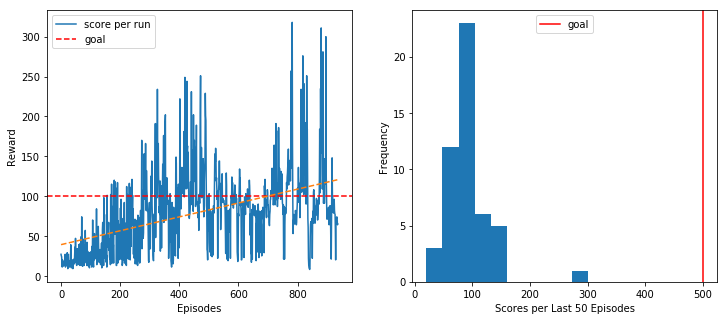

In [11]:
plot_res(scores)

In [13]:
_, a_model = actor_model(env.observation_space.shape, env.action_space.n)
a_model.load_weights('a_model.h5')

/home/mohanish3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_22 (Dense)             (None, 48)                1200      
_________________________________________________________________
dense_23 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 50        
Total params: 2,546
Trainable params: 2,546
Non-trainable params: 0
_________________________________________________________________
None


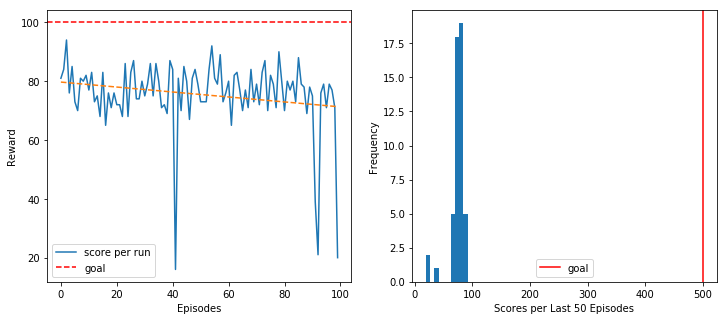

Average score over 100 episodes: 75.52


In [15]:
TEST_EPISODES = 100
goal_steps = 500
epsilon = 0.05
output_size = 2

scores = []
for episode in range(TEST_EPISODES):
    state = env.reset()
    
    score = 0
    for _ in range(goal_steps):
        env.render()
        
        action = next_action(state, output_size)
        
        new_state, reward, done, info = env.step(np.argmax(action))
        score += reward
        
        state = new_state
        if(done):
            break
            
    scores.append(score)
        
plot_res(scores)        
print("Average score over {} episodes: {}".format(TEST_EPISODES, sum(scores)/len(scores)))